<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importations" data-toc-modified-id="Importations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importations</a></span></li><li><span><a href="#Traitement-des-données" data-toc-modified-id="Traitement-des-données-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Traitement des données</a></span></li><li><span><a href="#Petits-modeles" data-toc-modified-id="Petits-modeles-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Petits modeles</a></span><ul class="toc-item"><li><span><a href="#Régularisation" data-toc-modified-id="Régularisation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Régularisation</a></span></li><li><span><a href="#Data-augmentation" data-toc-modified-id="Data-augmentation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data augmentation</a></span></li></ul></li><li><span><a href="#Grands-modeles" data-toc-modified-id="Grands-modeles-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Grands modeles</a></span><ul class="toc-item"><li><span><a href="#Data-augmentation" data-toc-modified-id="Data-augmentation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data augmentation</a></span></li></ul></li><li><span><a href="#Transfer-Learning" data-toc-modified-id="Transfer-Learning-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Transfer Learning</a></span><ul class="toc-item"><li><span><a href="#VGG16" data-toc-modified-id="VGG16-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>VGG16</a></span></li><li><span><a href="#NASNET" data-toc-modified-id="NASNET-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>NASNET</a></span></li><li><span><a href="#Tuning" data-toc-modified-id="Tuning-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Tuning</a></span></li></ul></li><li><span><a href="#Analyses-d'erreurs" data-toc-modified-id="Analyses-d'erreurs-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Analyses d'erreurs</a></span></li></ul></div>

Le but de ce notebook est d'effectuer de la classification d'images de chiens sur leur race.
Différents traitements sont effectués et plusieurs modèles sont entraînés.
Le transfert learning est également présent par l'utilisation de VGG16 et de NASNET.

# Importations

In [ ]:
import os

import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps 
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,\
                                    BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_uniform
from tensorboard.plugins.hparams import api as hp
import datetime


import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)
%load_ext tensorboard
!rm -rf ./logs/ 

Récupération des données brutes

In [ ]:
!unzip 'drive/My Drive/OC/Projet 6.zip'

Récupération des données traitées

In [ ]:
!unzip 'drive/My Drive/OC/data.zip'
races_list = os.listdir("data")

# Traitement des données

In [ ]:
races_list = os.listdir("Images")
annotions_list = os.listdir("Annotation")

print("{} races de chiens".format(len(races_list)))
print(races_list[:5])

120 races de chiens
['Great_Pyrenees', 'cairn', 'Old_English_sheepdog', 'Welsh_springer_spaniel', 'basset']


Le dataset comprends plus de 20000 images de chiens appartenant à 120 races différentes.

Affichons quelques images de la race "coated_wheaten_terrier"

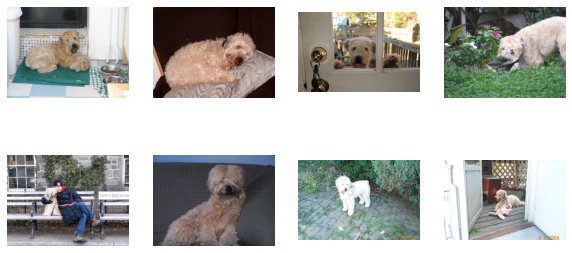

In [ ]:
plt.figure(figsize=(10,5))
images = os.listdir("Images/"+races_list[0])[:8]
for i in range(8):
    img = mpimg.imread("Images/"+races_list[0] + '/'+ images[i])
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis('off')

Nous pouvons remarquer que les images montrent bien chacunes un chien. Cependant nous notons qu'il y a beaucoup d'informations superflues étant donné que les chiens ne sont pas totalement centrés.

Ainsi nous allons utiliser l'autre dataset donné que indique la localisation du chien dans chaque image.

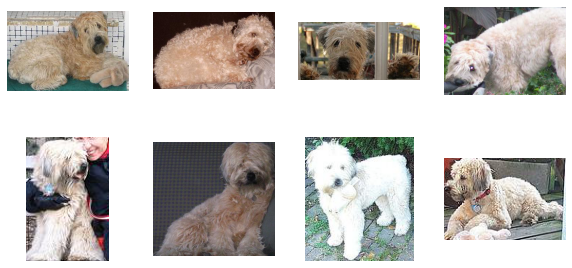

In [ ]:
plt.figure(figsize=(10,5))
for i, image in enumerate(images):
    img = Image.open('Images/{}/{}'.format(races_list[0], image))
    tree = ET.parse('Annotation/{}/{}'.format(races_list[0], image).replace(".jpg",""))
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    img = img.crop((xmin, ymin, xmax, ymax))
    img = img.convert('RGB')
    
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis('off')

Les images sont bien centrées sur le chien permettant ainsi de mieux entraîner nos modèles.

Effectuons ces traitements sur l'ensemble des images et sauvegardons-les pour les prochaines utilisations.

In [ ]:
os.mkdir('data')
for races in races_list:
    race = races.split("-")[1]
    os.mkdir('data/' + race)
    for image in os.listdir("Images/{}".format(races)):
        img = Image.open('Images/{}/{}'.format(races, image))
        tree = ET.parse('Annotation/{}/{}'.format(races, image).replace(".jpg",""))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.resize((224, 224))
        img = img.convert('RGB')
        img.save('data/' + race + '/' + image)

Regardons la distribution des classes

<BarContainer object of 120 artists>

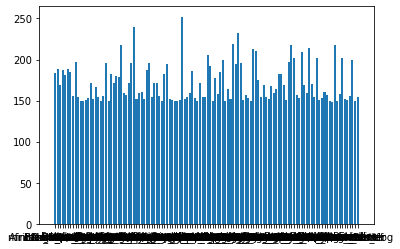

In [ ]:
dict_race = {}
for race in os.listdir("data"):
  dict_race[race] = len(os.listdir("data/"+race))

plt.bar(dict_race.keys(), dict_race.values())

Chaque race a environ 150 échantillons de races. Le jeu de données est plutôt bien balancé.

# Petits modeles

Commençons à générer un dataset pour l'entraînement et l'autre de validation. 

Ensuite, construisons un réseau de neurones assez simple

In [ ]:
datagen_base = ImageDataGenerator(rescale=1/255, 
                             validation_split=0.3)
train_data = datagen_base.flow_from_directory(batch_size=32,
                                         directory=r'data',
                                         shuffle=True,
                                         seed = 1,
                                         target_size=(224, 224),
                                         color_mode="rgb",
                                         subset="training",
                                         class_mode='categorical'
                                         )
validation_data = datagen_base.flow_from_directory(batch_size=32,
                                              directory=r'data',
                                              shuffle=True,
                                              seed = 1,
                                              target_size=(224, 224),
                                              color_mode="rgb",
                                              subset="validation",
                                              class_mode='categorical')

Found 14458 images belonging to 120 classes.
Found 6122 images belonging to 120 classes.


In [ ]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(len(races_list), activation='softmax')
  ])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 24, 128)      

Ce CNN a 5 couches et possède presque 10 millions de paramètres.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
log_dir = "logs/fit/Base_Model"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit_generator(generator=train_data,
                    validation_data=validation_data,
                    steps_per_epoch=len(train_data),
                    validation_steps=len(validation_data),
                    epochs=10,
                    callbacks=[tensorboard_callback]
)

Epoch 1/10
452/452 [==============================] - 38s 84ms/step - loss: 4.6897 - accuracy: 0.0163 - val_loss: 4.4696 - val_accuracy: 0.0343
Epoch 2/10
452/452 [==============================] - 38s 84ms/step - loss: 4.1044 - accuracy: 0.0724 - val_loss: 4.0030 - val_accuracy: 0.0835
Epoch 3/10
452/452 [==============================] - 38s 83ms/step - loss: 3.6289 - accuracy: 0.1419 - val_loss: 3.8540 - val_accuracy: 0.1103
Epoch 4/10
452/452 [==============================] - 38s 84ms/step - loss: 3.0869 - accuracy: 0.2439 - val_loss: 3.9643 - val_accuracy: 0.1312
Epoch 5/10
452/452 [==============================] - 37s 83ms/step - loss: 2.3363 - accuracy: 0.4056 - val_loss: 4.2611 - val_accuracy: 0.1184
Epoch 6/10
452/452 [==============================] - 38s 84ms/step - loss: 1.4972 - accuracy: 0.6042 - val_loss: 5.3713 - val_accuracy: 0.1094
Epoch 7/10
452/452 [==============================] - 38s 84ms/step - loss: 0.8137 - accuracy: 0.7789 - val_loss: 7.1578 - val_accuracy:

Au bout de 10 epochs, le CNN atteint 90% en taux de succès pour l'échantillon d'entraînement. Cependant, ce score n'est que de 13% pour l'échantillon de validation.



Nous sommes dans un cas de surapprentissage donc nous allons ajouter de la régularisation.

## Régularisation

In [ ]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(), 
    MaxPooling2D(2,2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(races_list), activation='softmax')
  ])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
log_dir = "logs/fit/Base_Model_Regularization"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit_generator(generator=train_data,
                    validation_data=validation_data,
                    steps_per_epoch=len(train_data),
                    validation_steps=len(validation_data),
                    epochs=10,
                    callbacks=[tensorboard_callback]
)

Epoch 1/10
452/452 [==============================] - 37s 82ms/step - loss: 5.0510 - accuracy: 0.0119 - val_loss: 4.7827 - val_accuracy: 0.0127
Epoch 2/10
452/452 [==============================] - 37s 82ms/step - loss: 4.7883 - accuracy: 0.0118 - val_loss: 4.7820 - val_accuracy: 0.0108
Epoch 3/10
452/452 [==============================] - 37s 82ms/step - loss: 4.7888 - accuracy: 0.0122 - val_loss: 4.7830 - val_accuracy: 0.0131
Epoch 4/10
452/452 [==============================] - 38s 83ms/step - loss: 4.7929 - accuracy: 0.0124 - val_loss: 4.7839 - val_accuracy: 0.0106
Epoch 5/10
452/452 [==============================] - 38s 85ms/step - loss: 4.7812 - accuracy: 0.0122 - val_loss: 4.7780 - val_accuracy: 0.0131
Epoch 6/10
452/452 [==============================] - 38s 84ms/step - loss: 4.7804 - accuracy: 0.0122 - val_loss: 4.7798 - val_accuracy: 0.0123
Epoch 7/10
452/452 [==============================] - 38s 84ms/step - loss: 4.7800 - accuracy: 0.0122 - val_loss: 4.7797 - val_accuracy:

Les taux de succès des deux jeux de données sont maintenant sensiblement égaux. Cependant, ils n'atteignent qu'un peu plus de 1%.

Pour améliorer ce score, nous pouvons employer de l'augmentation de données.

## Data augmentation

Nous allons employer la data augmentation sur le jeu de données d'entraînement en effectuant plusieurs transformations tels que des zoomages, des rotations, des changements d'intensités lumineuses, etc.


Regardons un exemple à partir de cette image

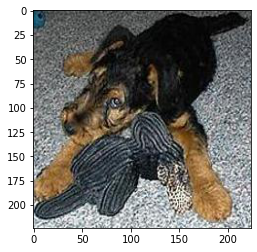

In [ ]:
img = mpimg.imread("data/Airedale/n02096051_129.jpg")
plt.imshow(img)

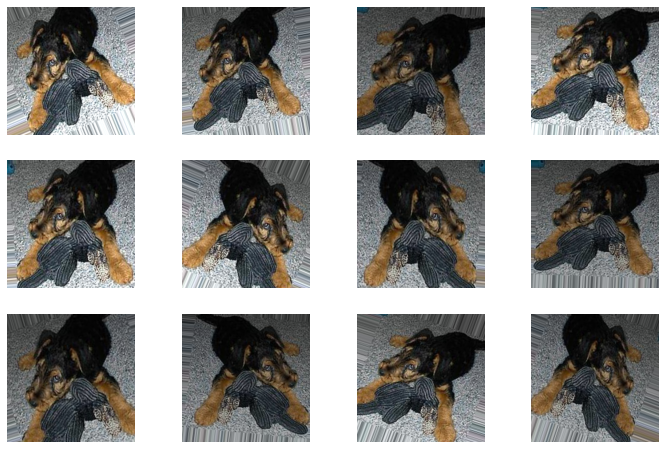

In [ ]:
datagen = ImageDataGenerator(zoom_range=0.1,
                             brightness_range=[0.7,1.2],
                             rotation_range=25,
                             horizontal_flip=True,
                             zca_whitening = True,
                             height_shift_range=0.05,
                             width_shift_range=0.05)
iter_data = datagen.flow(np.expand_dims(img, 0), batch_size=1)
plt.figure(figsize=(12,8))

for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(iter_data.next()[0].astype('int'))
    plt.axis('off')

L'image initiale a été transformée aléatoirement 12 fois ci-dessus. Nous observons bien les différences de luminosité ou les rotations effectuées.

In [ ]:
datagen = ImageDataGenerator(rescale=1/255, 
                             validation_split=0.3, 
                             zoom_range=0.1,
                             brightness_range=[0.7,1.2],
                             rotation_range=25,
                             horizontal_flip=True,
                             zca_whitening = True,
                             height_shift_range=0.05,
                             width_shift_range=0.05)
datagen_val = ImageDataGenerator(rescale=1/255, 
                             validation_split=0.3)
train_data = datagen.flow_from_directory(batch_size=32,
                                         directory=r'data',
                                         shuffle=True,
                                         seed = 1,
                                         target_size=(224, 224),
                                         color_mode="rgb",
                                         subset="training",
                                         class_mode='categorical'
                                         )
validation_data = datagen_val.flow_from_directory(batch_size=32,
                                              directory=r'data',
                                              shuffle=True,
                                              seed = 1,
                                              target_size=(224, 224),
                                              color_mode="rgb",
                                              subset="validation",
                                              class_mode='categorical')

Found 14458 images belonging to 120 classes.
Found 6122 images belonging to 120 classes.


In [ ]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(len(races_list), activation='softmax')
  ])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 24, 24, 128)      

En effectuant des tests au préalable, mettre le learning_rate à 0.001 semble être favorable au modèle.

De plus, comme nous utilisons la fonction d'activation ReLu, il est préférable d'initialiser les paramètres avec l'initialisation de He.

In [ ]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu', kernel_initializer=he_uniform()),
    Dense(len(races_list), activation='softmax')
  ])
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/Base_Model_DataAugmentation"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit_generator(generator=train_data,
                    validation_data=validation_data,
                    steps_per_epoch=len(train_data),
                    validation_steps=len(validation_data),
                    epochs=50,
                    callbacks=[tensorboard_callback]
)

Au bout d'une vingtaine d'epoch, la fonction d'objectif se détériore ainsi nous pouvons arrêtre l'exécition à 25 epoch.

Etant donné qu'aucune technique de régularisation n'est employée, le taux de succès du dataset d'entraînement est meilleur que celui de validation.

Cependant, avec la data augmentation, nous parvenons à obtenir un taux de succès d'environ 26%.


# Grands modeles


Entraînons maintenant des modèles plus profonds.

Nous allons nous inspirer du modèle VGG16 avec cependant moins de couches.

In [ ]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_initializer=he_uniform()),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    BatchNormalization(), 
    Conv2D(64, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    Conv2D(256, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    Conv2D(512, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    Conv2D(512, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),    
    Conv2D(512, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    Conv2D(512, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    Conv2D(256, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),    
    Flatten(),
    Dense(512, activation='relu', kernel_initializer=he_uniform()),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer=he_uniform()),
    Dropout(0.5),
    Dense(len(races_list), activation='softmax')
  ])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 110, 110, 64)      0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 110, 110, 64)      256       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 108, 108, 64)      36928     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 106, 106, 128)     73856     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 53, 53, 128)     

Ce modèle a 14 couches, soit presque 3 fois plus que le CNN précédent, avec uniquement 1 million de paramètre en plus.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
log_dir = "logs/fit/Deep_Model"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit_generator(generator=train_data,
                    validation_data=validation_data,
                    steps_per_epoch=len(train_data),
                    validation_steps=len(validation_data),
                    epochs=100, 
                    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)

Le modèle fait au maximum 47% de taux de succès sur les données de validation. 

Comme nous observons un effet d'overfitting, malgré la présence de dropout, nous allons tester avec la data augmentation.

## Data augmentation

In [ ]:
datagen = ImageDataGenerator(rescale=1/255, 
                             validation_split=0.3, 
                             zoom_range=0.1,
                             brightness_range=[0.7,1.2],
                             rotation_range=25,
                             horizontal_flip=True,
                             zca_whitening = True,
                             height_shift_range=0.05,
                             width_shift_range=0.05)
datagen_val = ImageDataGenerator(rescale=1/255, 
                             validation_split=0.3)
train_data = datagen.flow_from_directory(batch_size=128,
                                         directory=r'data',
                                         shuffle=True,
                                         seed = 1,
                                         target_size=(224, 224),
                                         color_mode="rgb",
                                         subset="training",
                                         class_mode='categorical'
                                         )
validation_data = datagen_val.flow_from_directory(batch_size=128,
                                              directory=r'data',
                                              shuffle=True,
                                              seed = 1,
                                              target_size=(224, 224),
                                              color_mode="rgb",
                                              subset="validation",
                                              class_mode='categorical')

Found 14458 images belonging to 120 classes.
Found 6122 images belonging to 120 classes.


In [ ]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_initializer=he_uniform()),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    BatchNormalization(), 
    Conv2D(64, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    Conv2D(256, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    Conv2D(512, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    Conv2D(512, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),    
    Conv2D(512, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    Conv2D(512, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    Conv2D(256, (3, 3), activation='relu', kernel_initializer=he_uniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),    
    Flatten(),
    Dense(512, activation='relu', kernel_initializer=he_uniform()),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer=he_uniform()),
    Dropout(0.5),
    Dense(len(races_list), activation='softmax')
  ])
model.compile(optimizer=Adam(learning_rate=0.0005, beta_1=0.95),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/Deep_Model_DataAugmentation"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit_generator(generator=train_data,
                    validation_data=validation_data,
                    steps_per_epoch=len(train_data),
                    validation_steps=len(validation_data),
                    epochs=100, 
                    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)

Le modèle arrive maintenant a atteindre 48% de taux de succès. 

# Transfer Learning

Pour essayer d'améliorer nos résultats, nous allons utiliser le transfer learning. En commençant par le VGG16.

## VGG16

In [ ]:
datagen = ImageDataGenerator(rescale=1/255, 
                             validation_split=0.3, 
                             zoom_range=0.1,
                             brightness_range=[0.7,1.2],
                             rotation_range=25,
                             horizontal_flip=True,
                             zca_whitening = True,
                             height_shift_range=0.05,
                             width_shift_range=0.05)
datagen_val = ImageDataGenerator(rescale=1/255, 
                             validation_split=0.3)
train_data = datagen.flow_from_directory(batch_size=128,
                                         directory=r'data',
                                         shuffle=True,
                                         seed = 1,
                                         target_size=(224, 224),
                                         color_mode="rgb",
                                         subset="training",
                                         class_mode='categorical'
                                         )
validation_data = datagen_val.flow_from_directory(batch_size=128,
                                              directory=r'data',
                                              shuffle=True,
                                              seed = 1,
                                              target_size=(224, 224),
                                              color_mode="rgb",
                                              subset="validation",
                                              class_mode='categorical')

Found 14458 images belonging to 120 classes.
Found 6122 images belonging to 120 classes.


In [ ]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top = False, pooling='avg', input_shape=(224, 224, 3))
print(base_model.summary())

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

Nous notons que le modèle est plus profond que le notre et possède plus de 14 millions de paramètres déjà entraînés.

In [ ]:
base_model.trainable = False
model = tf.keras.models.Sequential([
     base_model,
     Dense(512, activation='relu', kernel_initializer=he_uniform()),
     Dense(256, activation='relu', kernel_initializer=he_uniform()),
     Dense(len(races_list), activation='softmax')                               
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/TL_Model_VGG16"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit_generator(generator=train_data,
                    validation_data=validation_data,
                    steps_per_epoch=len(train_data),
                    validation_steps=len(validation_data),
                    epochs=100, 
                    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)

Nous notons qu'avec 50 epochs, le modèle n'atteint que 43% de taux de succès. Cependant, nous remarquons qu'il converge au départ plus rapidement.

In [ ]:
base_model.trainable = False

for l in base_model.layers[-4:]:
  l.trainable = True

model = tf.keras.models.Sequential([
     base_model,
     Dense(128, activation='relu', kernel_initializer=he_uniform()),
     Dense(len(races_list), activation='softmax')                               
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/TL_Model_FT_VGG16"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit_generator(generator=train_data,
                    validation_data=validation_data,
                    steps_per_epoch=len(train_data),
                    validation_steps=len(validation_data),
                    epochs=100, 
                    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)

En utilisant le fine tuning, donc entraînant les paramètres du modèle, les résultats obtenus ne sont pas meilleurs.


## NASNET

Prenons un autre modèle plus complexe.

In [ ]:
base_model = tf.keras.applications.NASNetLarge(weights='imagenet', pooling='avg', include_top = False)

343613440/343610240 [==============================] - 3s 0us/step


In [ ]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

Ce modèle est bien plus complexe que les précédents et possède presque 85 millions de paramètres.

In [ ]:
datagen = ImageDataGenerator(rescale=1/255, 
                             validation_split=0.3)
train_data = datagen.flow_from_directory(batch_size=128,
                                         directory=r'data',
                                         shuffle=True,
                                         seed = 1,
                                         target_size=(331, 331),
                                         color_mode="rgb",
                                         subset="training",
                                         class_mode='categorical'
                                         )
validation_data = datagen.flow_from_directory(batch_size=128,
                                              directory=r'data',
                                              shuffle=False,
                                              seed = 1,
                                              target_size=(331, 331),
                                              color_mode="rgb",
                                              subset="validation",
                                              class_mode='categorical')



Found 14458 images belonging to 120 classes.
Found 6122 images belonging to 120 classes.


In [ ]:
base_model.trainable = False

model = tf.keras.models.Sequential([
     base_model,
     Dense(512, activation='relu', kernel_initializer=he_uniform()),
     Dropout(0.5),
     Dense(512, activation='relu', kernel_initializer=he_uniform()),
     Dropout(0.5),
     Dense(len(races_list), activation='softmax')                               
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/TL_Model_NASNetLarge"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit_generator(generator=train_data,
                    validation_data=validation_data,
                    steps_per_epoch=len(train_data),
                    validation_steps=len(validation_data),
                    epochs=10,
                    callbacks=[tensorboard_callback]
)

Epoch 1/10
113/113 [==============================] - 356s 3s/step - loss: 1.1248 - accuracy: 0.7679 - val_loss: 0.2611 - val_accuracy: 0.9327
Epoch 2/10
113/113 [==============================] - 351s 3s/step - loss: 0.3631 - accuracy: 0.9124 - val_loss: 0.2777 - val_accuracy: 0.9307
Epoch 3/10
113/113 [==============================] - 351s 3s/step - loss: 0.3022 - accuracy: 0.9228 - val_loss: 0.2774 - val_accuracy: 0.9291
Epoch 4/10
113/113 [==============================] - 350s 3s/step - loss: 0.2761 - accuracy: 0.9276 - val_loss: 0.2667 - val_accuracy: 0.9311
Epoch 5/10
113/113 [==============================] - 350s 3s/step - loss: 0.2545 - accuracy: 0.9312 - val_loss: 0.2745 - val_accuracy: 0.9337
Epoch 6/10
113/113 [==============================] - 350s 3s/step - loss: 0.2400 - accuracy: 0.9329 - val_loss: 0.2935 - val_accuracy: 0.9271
Epoch 7/10
113/113 [==============================] - 351s 3s/step - loss: 0.2255 - accuracy: 0.9395 - val_loss: 0.2993 - val_accuracy: 0.9285

Dès le premier epoch, le modèle atteint 93% de réussite avec pour maximum 93.11% au quatrième epoch.

Testons avec de l'augmentation de données.

In [ ]:
datagen = ImageDataGenerator(rescale=1/255, 
                             validation_split=0.3, 
                             zoom_range=0.1,
                             brightness_range=[0.7,1.2],
                             rotation_range=25,
                             horizontal_flip=True,
                             zca_whitening = True,
                             height_shift_range=0.05,
                             width_shift_range=0.05)
datagen_val = ImageDataGenerator(rescale=1/255, 
                             validation_split=0.3)
train_data = datagen.flow_from_directory(batch_size=128,
                                         directory=r'data',
                                         shuffle=True,
                                         seed = 1,
                                         target_size=(224, 224),
                                         color_mode="rgb",
                                         subset="training",
                                         class_mode='categorical'
                                         )
validation_data = datagen_val.flow_from_directory(batch_size=128,
                                              directory=r'data',
                                              shuffle=True,
                                              seed = 1,
                                              target_size=(224, 224),
                                              color_mode="rgb",
                                              subset="validation",
                                              class_mode='categorical')
base_model.trainable = False

model = tf.keras.models.Sequential([
     base_model,
     Dense(512, activation='relu', kernel_initializer=he_uniform()),
     Dropout(0.5),
     Dense(512, activation='relu', kernel_initializer=he_uniform()),
     Dropout(0.5),
     Dense(len(races_list), activation='softmax')                               
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/TL_Model_NASNetLarge_DA"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit_generator(generator=train_data,
                    validation_data=validation_data,
                    steps_per_epoch=len(train_data),
                    validation_steps=len(validation_data),
                    epochs=100, 
                    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)

Après 40 epochs, le meilleur résultat n'est pas meilleur que précédemment étant donné que nous obtenons maximum 91% de taux de succès

## Tuning

Nous allons maintenant effectuer une recherche d'hyperparmètres en jouant sur le nombre de neurones par couches, l'intensité de dropout, le coefficent d'apprentissage et le beta_1 utilisé pour l'optimizer Adam.

Nous emploierons un random search pour cela avec 10 itérations. Le temps d'éxecution étant assez lent, nous allons pas effectuer plus de recherches.

In [ ]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([512, 1024, 2048]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([256, 512, 1024]))
HP_DROPOUT_1 = hp.HParam('dropout_1', hp.RealInterval(0.4, 0.6))
HP_DROPOUT_2 = hp.HParam('dropout_2', hp.RealInterval(0.4, 0.6))
HP_LR = hp.HParam('lr', hp.RealInterval(0.00001, 0.001))
HP_BETA = hp.HParam('beta', hp.RealInterval(0.9, 0.999))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1, HP_NUM_UNITS_2, HP_DROPOUT_1, HP_DROPOUT_2, HP_LR, HP_BETA],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def random_model(hparams, i):
  base_model.trainable = False

  model = tf.keras.models.Sequential([
      base_model,
      Dense(hparams[HP_NUM_UNITS_1], activation='relu', kernel_initializer=he_uniform()),
      Dropout(hparams[HP_DROPOUT_1]),
      Dense(hparams[HP_NUM_UNITS_2], activation='relu', kernel_initializer=he_uniform()),
      Dropout(hparams[HP_DROPOUT_2]),
      Dense(len(races_list), activation='softmax')                               
  ])
  model.compile(optimizer=Adam(learning_rate=hparams[HP_LR], beta_1=hparams[HP_BETA]),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  history = model.fit_generator(generator=train_data,
                                validation_data=validation_data,
                                steps_per_epoch=len(train_data),
                                validation_steps=len(validation_data),
                                epochs=10,
                                callbacks=[tf.keras.callbacks.TensorBoard(log_dir="logs/fit/TL_Model_NASNetLarge_FT_"+str(i), histogram_freq=1),
                                          hp.KerasCallback("logs/hparam_tuning/TL_Model_NASNetLarge_FT_"+str(i), hparams)])
  return np.max(history.history['val_accuracy']), np.argmax(history.history['val_accuracy'])

In [ ]:
best_dict = {'nb1': None, 'nb2': None, 'dp1': None, 'dp2': None, 'lr': None, 'beta': None}
min_acc = 0
ind_epoch = 0
it = None

for i in range(10):
  print("Itération n°", i + 1)
  nb_1 = np.random.choice(HP_NUM_UNITS_1.domain.values)
  nb_2 = np.random.choice(HP_NUM_UNITS_2.domain.values)
  drop_1 = np.random.uniform(HP_DROPOUT_1.domain.min_value, HP_DROPOUT_1.domain.max_value)
  drop_2 = np.random.uniform(HP_DROPOUT_2.domain.min_value, HP_DROPOUT_2.domain.max_value)
  lr = 10**np.random.uniform(np.log10(HP_LR.domain.max_value), np.log10(HP_LR.domain.min_value))
  beta = 1-(10**np.random.uniform(np.log10(1-HP_BETA.domain.max_value), np.log10(1-HP_BETA.domain.min_value)))
  
  print("Nb neurones 1 : ",nb_1)
  print("Nb neurones 2 : ",nb_2)
  print("Dropout 1 : ",drop_1)
  print("Dropout 2 : ",drop_2)
  print("Learning rate : ",lr)
  print("Beta : ", beta)

  hparams = {
          HP_NUM_UNITS_1: nb_1,
          HP_NUM_UNITS_2: nb_2,
          HP_DROPOUT_1: drop_1,
          HP_DROPOUT_2: drop_2,
          HP_LR: lr,
          HP_BETA: beta,
  }
  acc, ep = random_model(hparams, i)

  if acc > min_acc:
    best_dict['nb1'] = nb_1
    best_dict['nb2'] = nb_2
    best_dict['dp1'] = drop_1
    best_dict['dp2'] = drop_2
    best_dict['lr'] = lr
    best_dict['beta'] = beta
    ind_epoch = ep + 1
    min_acc = acc
    it = i + 1

  print("Taux de succès : ",acc)

print("------------------")
print("Top accuracy : ", min_acc, " with ", ind_epoch, " epochs", " iteration : ", it)
print(best_dict)

Itération n° 1
Nb neurones 1 :  1024
Nb neurones 2 :  256
Dropout 1 :  0.5865114718677318
Dropout 2 :  0.42562488958587136
Learning rate :  1.0044283665868866e-05
Beta :  0.9970339535100061
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
113/113 [==============================] - 359s 3s/step - loss: 4.7563 - accuracy: 0.0184 - val_loss: 4.5304 - val_accuracy: 0.1790
Epoch 2/10
113/113 [==============================] - 350s 3s/step - loss: 4.5158 - accuracy: 0.0678 - val_loss: 4.2915 - val_accuracy: 0.5849
Epoch 3/10
113/113 [==============================] - 350s 3s/step - loss: 4.2856 - accuracy: 0.1648 - val_loss: 4.0260 - val_accuracy: 0.7886
Epoch 4/10
113/113 [==============================] - 350s 3s/step - loss: 4.0417 - accuracy: 0.2693 - val_loss: 3.7021 - val_accuracy: 0.8479
Epoch 5/10
113/113 [==============================] - 350s 3s/step - loss: 3.7621 - accuracy: 0.3701 - val_loss: 3.3176 - val_accuracy: 0.8737
Epoch 6/10
113/113 

Nous pouvons atteindre 93.5% de succès en jouant avec le hyperparamètre. 

En observant de plus près les résultats du modèle fournissant ce taux de réussite, nous pouvons noter que le modèle peut potentiellement avoir un meilleur succès. Ainsi, nous allons le reprendre et le ré-entraîner avec les mêmes hyperparamètres.

In [ ]:
base_model.trainable = False

model = tf.keras.models.Sequential([
     base_model,
     Dense(2048, activation='relu', kernel_initializer=he_uniform()),
     Dropout(0.46),
     Dense(512, activation='relu', kernel_initializer=he_uniform()),
     Dropout(0.45),
     Dense(len(races_list), activation='softmax')                               
])
model.compile(optimizer=Adam(learning_rate=0.00002053, beta_1=0.9908),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/TL_Model_NASNetLarge_FT"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit_generator(generator=train_data,
                    validation_data=validation_data,
                    steps_per_epoch=len(train_data),
                    validation_steps=len(validation_data),
                    epochs=20,
                    callbacks=[tensorboard_callback]
)

Epoch 1/20
113/113 [==============================] - 358s 3s/step - loss: 4.3808 - accuracy: 0.1657 - val_loss: 3.6907 - val_accuracy: 0.8533
Epoch 2/20
113/113 [==============================] - 352s 3s/step - loss: 3.2160 - accuracy: 0.6160 - val_loss: 2.0791 - val_accuracy: 0.9007
Epoch 3/20
113/113 [==============================] - 352s 3s/step - loss: 1.7996 - accuracy: 0.8039 - val_loss: 0.7397 - val_accuracy: 0.9203
Epoch 4/20
113/113 [==============================] - 352s 3s/step - loss: 0.8522 - accuracy: 0.8797 - val_loss: 0.3260 - val_accuracy: 0.9286
Epoch 5/20
113/113 [==============================] - 352s 3s/step - loss: 0.4989 - accuracy: 0.9039 - val_loss: 0.2578 - val_accuracy: 0.9332
Epoch 6/20
113/113 [==============================] - 352s 3s/step - loss: 0.3798 - accuracy: 0.9155 - val_loss: 0.2440 - val_accuracy: 0.9350
Epoch 7/20
113/113 [==============================] - 352s 3s/step - loss: 0.3392 - accuracy: 0.9188 - val_loss: 0.2414 - val_accuracy: 0.9343

Nous obtenons au mieux 93.61%.

Sauvegardons le modèle.

In [ ]:
model.save('TL_Model_NASNetLarge_FT.h5')

# Analyses d'erreurs

En fonction du dernier modèle, nous allons regarder les différentes erreurs qu'il a effectué.

In [ ]:
datagen = ImageDataGenerator(rescale=1/255, 
                             validation_split=0.3)
validation_data = datagen.flow_from_directory(batch_size=1,
                                              directory=r'data',
                                              shuffle=False,
                                              target_size=(331, 331),
                                              color_mode="rgb",
                                              subset="validation",
                                              class_mode='categorical')
predictions = model.predict_generator(validation_data, steps=len(validation_data.classes))
predictions

Found 6122 images belonging to 120 classes.


array([[9.9942708e-01, 9.4085244e-06, 1.6468196e-06, ..., 2.4645421e-06,
        2.2143836e-06, 1.3158597e-06],
       [9.9963975e-01, 5.8137025e-06, 5.3983007e-07, ..., 1.5148343e-06,
        1.2255189e-06, 1.0724281e-06],
       [9.9975687e-01, 3.5442288e-06, 4.3988433e-07, ..., 9.4073613e-07,
        9.3047964e-07, 7.5087911e-07],
       ...,
       [1.9993195e-05, 3.1564518e-06, 5.6991554e-05, ..., 1.2809741e-06,
        1.8285651e-05, 9.9530786e-01],
       [3.4194447e-05, 4.8655365e-06, 4.4934059e-04, ..., 1.5929359e-06,
        2.3835513e-05, 9.9501711e-01],
       [5.2390940e-05, 1.0177098e-05, 3.0687530e-04, ..., 5.2179189e-06,
        3.1307813e-05, 9.8480475e-01]], dtype=float32)

Vérifions que le taux de succès soit bien cohérent

In [ ]:
list_race = np.array([race for race in sorted(os.listdir("data"))])
y = validation_data.classes
predictions_sup = np.argmax(predictions, axis=1)
incorrect_pred = np.where(y != predictions_sup)[0]
np.mean(y == predictions_sup)

0.9353152564521399

Trions dans l'ordre décroissant les races de chiens ayant eu le plus d'erreur de prédiction

In [ ]:
unique, counts = np.unique(y[incorrect_pred], return_counts=True)
incorrect_dict = dict(zip(unique, counts))
[(it[0],list_race[it[0]], it[1]) for it in sorted(incorrect_dict.items(), key=lambda x: x[1], reverse=True)]

[(24, 'Eskimo_dog', 19),
 (89, 'collie', 19),
 (20, 'English_foxhound', 16),
 (63, 'Shih', 12),
 (64, 'Siberian_husky', 12),
 (114, 'standard_schnauzer', 11),
 (115, 'toy_poodle', 11),
 (104, 'miniature_poodle', 10),
 (3, 'American_Staffordshire_terrier', 9),
 (4, 'Appenzeller', 9),
 (43, 'Lhasa', 9),
 (47, 'Norfolk_terrier', 8),
 (31, 'Greater_Swiss_Mountain_dog', 7),
 (68, 'Tibetan_terrier', 7),
 (119, 'wire', 7),
 (5, 'Australian_terrier', 6),
 (23, 'EntleBucher', 6),
 (41, 'Lakeland_terrier', 6),
 (62, 'Shetland_sheepdog', 6),
 (65, 'Staffordshire_bullterrier', 6),
 (73, 'Yorkshire_terrier', 6),
 (92, 'dingo', 6),
 (111, 'silky_terrier', 6),
 (118, 'whippet', 6),
 (36, 'Irish_wolfhound', 5),
 (46, 'Newfoundland', 5),
 (49, 'Norwich_terrier', 5),
 (54, 'Rhodesian_ridgeback', 5),
 (69, 'Walker_hound', 5),
 (101, 'malamute', 5),
 (116, 'toy_terrier', 5),
 (15, 'Cardigan', 4),
 (34, 'Irish_terrier', 4),
 (40, 'Labrador_retriever', 4),
 (44, 'Maltese_dog', 4),
 (59, 'Scotch_terrier', 4)

In [ ]:
Regardons les mauvaises prédictions de la race Eskimo_dog

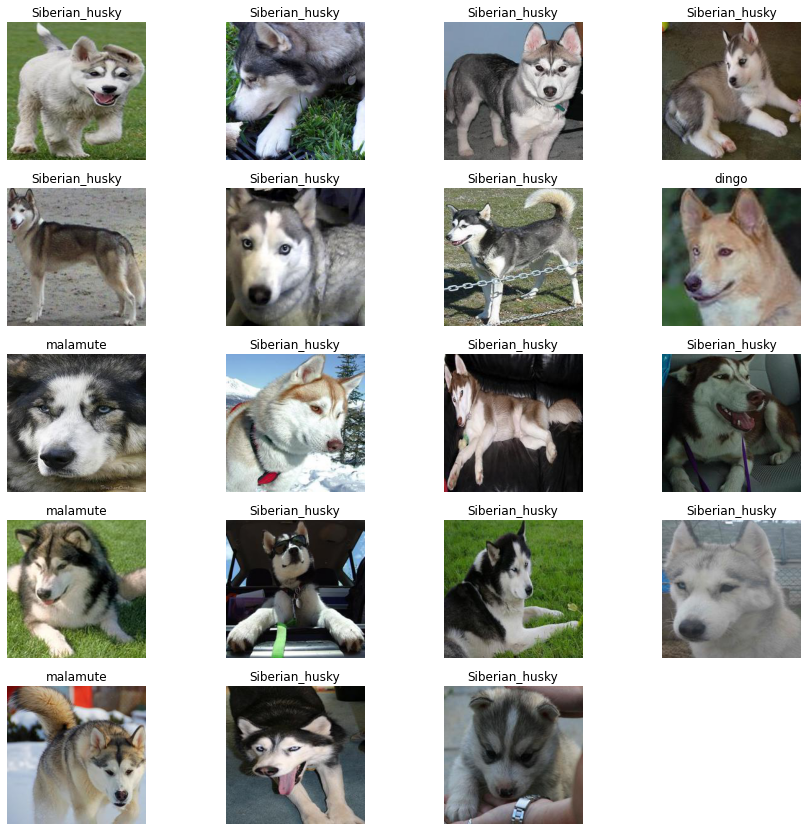

In [ ]:
plt.figure(figsize=(15,30))
j = 0
for i in incorrect_pred[np.where(y[incorrect_pred] == 24)[0]]:
    plt.subplot(10, 4, j+1)
    plt.imshow(mpimg.imread('data/'+validation_data.filenames[i]))
    plt.title(list_race[predictions_sup[i]])
    plt.axis('off')
    j += 1


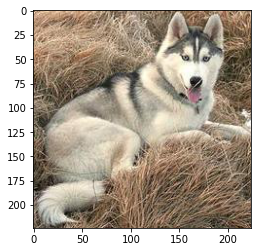

In [ ]:
plt.imshow(mpimg.imread('data/Siberian_husky/n02110185_10047.jpg'))

Nous voyons que la plupart des mauvaises prédictions font référence aux Husky sibériens qui est une race de chien leur ressemblant fortement.

Parmi les mauvaises prédictions, un dingo a été annoté sûrement dû à la couleur de son pelage.

Regardons maintenant pour la race 'collie'

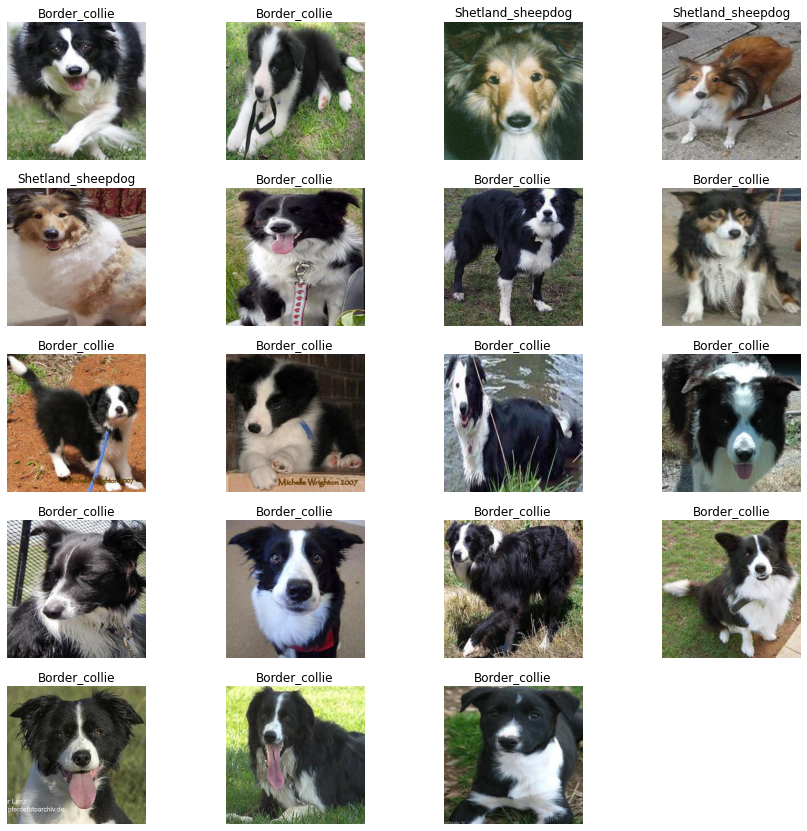

In [ ]:
plt.figure(figsize=(15,30))
j = 0
for i in incorrect_pred[np.where(y[incorrect_pred] == 89)[0]]:
    plt.subplot(10, 4, j+1)
    plt.imshow(mpimg.imread('data/'+validation_data.filenames[i]))
    plt.title(list_race[predictions_sup[i]])
    plt.axis('off')
    j += 1

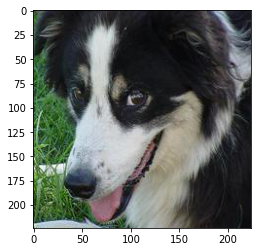

In [ ]:
plt.imshow(mpimg.imread('data/Border_collie/n02106166_1032.jpg'))

Les mauvaises prédictions pour cette race semble être juste étant donné qu'elles sont pour la plupart des Border collie.

En explorant les données, beaucoup d'images pour la race collie ont été mal annotées.